In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pycountry
from pprint import pprint
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

plt.rcParams["figure.figsize"] = (16, 10)

# Reading reports from file

In [2]:
who_daily_reports_dir_name = "who_daily_reports"

In [3]:
column_names = ['Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']
new_column_names = ['Province_State', 'Country_Region', 'Confirmed', 'Deaths', 'Recovered']

reports_files_names = sorted(os.listdir(who_daily_reports_dir_name))
reports = []
for report_file_name in reports_files_names:
    date = datetime.strptime(report_file_name[:-4], '%m-%d-%Y')
    dataframe = pd.read_csv(os.path.join(who_daily_reports_dir_name, report_file_name))
    
    try:
        dataframe = dataframe[column_names]
    except KeyError:
        dataframe = dataframe[new_column_names]
        dataframe = dataframe.rename(columns={'Province_State': 'Province/State', 'Country_Region': 'Country/Region'})
    
    dataframe['Province/State'].fillna("NotSpecified", inplace=True)
    dataframe.fillna(0, inplace=True)

    dataframe = dataframe.astype({'Confirmed': 'int32', 'Deaths': 'int32', 'Recovered': 'int32'}, copy=False)
    
    reports.append((date, dataframe))
    
reports = np.array(reports)

In [4]:
reports[-1, 1].head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,South Carolina,United States,24,0,0
1,Louisiana,United States,129,7,0
2,Virginia,United States,100,3,0
3,Idaho,United States,642,14,0
4,Iowa,United States,1,0,0


# Getting all countries from the reports

In [5]:
def get_all_countries():
    countries = []
    for report in reports[:, 1]:
        column_values = report[["Country/Region"]].values
        countries += np.unique(column_values).tolist()
    return np.unique(countries)
    
countries = get_all_countries()

# Getting characteristic for all countries

In [6]:
CONFIRMED = "Confirmed"
DEATHS = "Deaths"
RECOVERED = "Recovered"

countres_characteristic  = {}
for country in countries:
    countres_characteristic[country] = {CONFIRMED:[], DEATHS:[], RECOVERED: []}

for report in reports[:, 1]:
    region_aggregated_stats = report.groupby('Country/Region').sum()
    for index, row in region_aggregated_stats.iterrows():
        countres_characteristic[index][CONFIRMED].append(row[CONFIRMED])
        countres_characteristic[index][DEATHS].append(row[DEATHS])
        countres_characteristic[index][RECOVERED].append(row[RECOVERED])

# pprint(countres_characteristic)

# Filtering countries which meet the constraints

1. The epidemy starts when there are epidemy_start_cases_number number of cases.
2. Epidemy lasts for at least day_range days.

In [7]:
countries_with_enough_data = {}

epidemy_start_cases_number = 20
day_range = 40

for country, data in countres_characteristic.items():
    confirmed = [i for i in data[CONFIRMED] if i >= epidemy_start_cases_number]
    epidemy_days = len(confirmed)
    if  epidemy_days < day_range:
        continue
    confirmed = confirmed[:day_range]
    deaths = data[DEATHS][-epidemy_days:]
    deaths = deaths[:day_range]
    recovered = data[RECOVERED][-epidemy_days:]
    recovered = recovered[:day_range]
    countries_with_enough_data[country] = {CONFIRMED : confirmed, DEATHS : deaths, RECOVERED : recovered}
#     print(len(confirmed), len(deaths), len(recovered))

# Creating countries characteristics vector

In [8]:
vectors = []
countries = []
for country, data in countries_with_enough_data.items():
    vector = []
    for day in range (1,day_range):
        vector.append((data[CONFIRMED][day] - data[CONFIRMED][day - 1])/ data[CONFIRMED][day - 1])
    for day in range (1,day_range):
        if(data[DEATHS][day - 1] == 0):
            vector.append(0)
        else:
            vector.append((data[DEATHS][day] - data[DEATHS][day - 1])/ data[DEATHS][day - 1])
    for day in range (1,day_range):
        if(data[RECOVERED][day - 1] == 0):
            vector.append(0)
        else:
            vector.append((data[RECOVERED][day] - data[RECOVERED][day - 1])/ data[RECOVERED][day - 1])
    vectors.append(vector)
    countries.append(country)
vectors = np.array(vectors)
vectors.shape

(84, 117)

# Clustering

/home/julia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


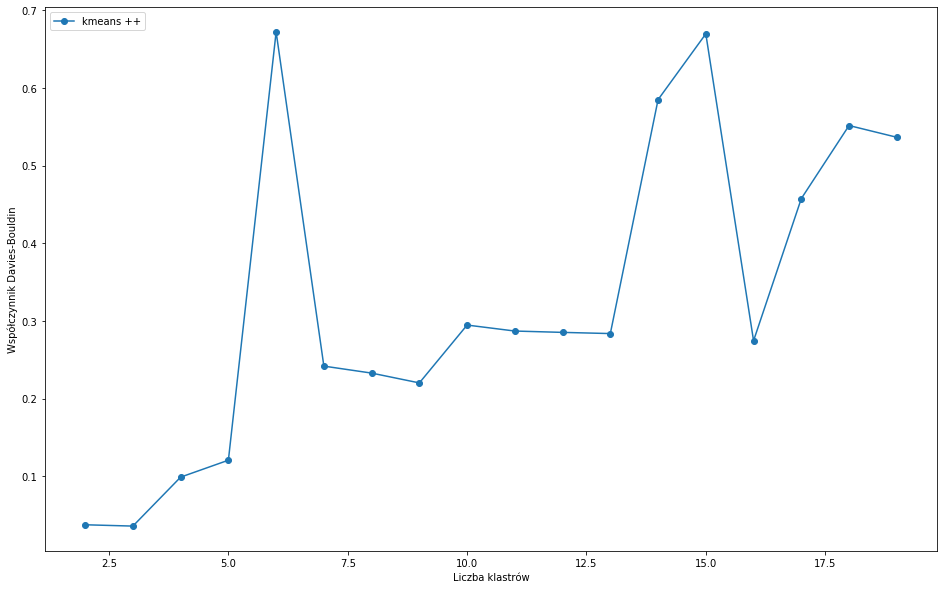

In [9]:
def get_score(ds,clusters):
    kmeans = KMeans(n_clusters=clusters, n_init = 5).fit(ds)
    labels = kmeans.labels_
    return davies_bouldin_score(ds, labels)

def get_score_for_number_of_clusters(ds):
    results = []
    for clusters in range(2, 20):
        results.append(get_score(ds, clusters))
    return results


def visualize_score_graph_number_of_clusters(ds):
    results = get_score_for_number_of_clusters(ds)
    ax = plt.plot(range(2, 20), results, marker='o',label="kmeans ++")
    ax = plt.axes()
    ax.set_xlabel("Liczba klastrów")
    ax.set_ylabel("Współczynnik Davies-Bouldin")
    ax.legend(loc='upper left', numpoints=1)
    plt.show()
    
visualize_score_graph_number_of_clusters(vectors)
    

# Visualization 

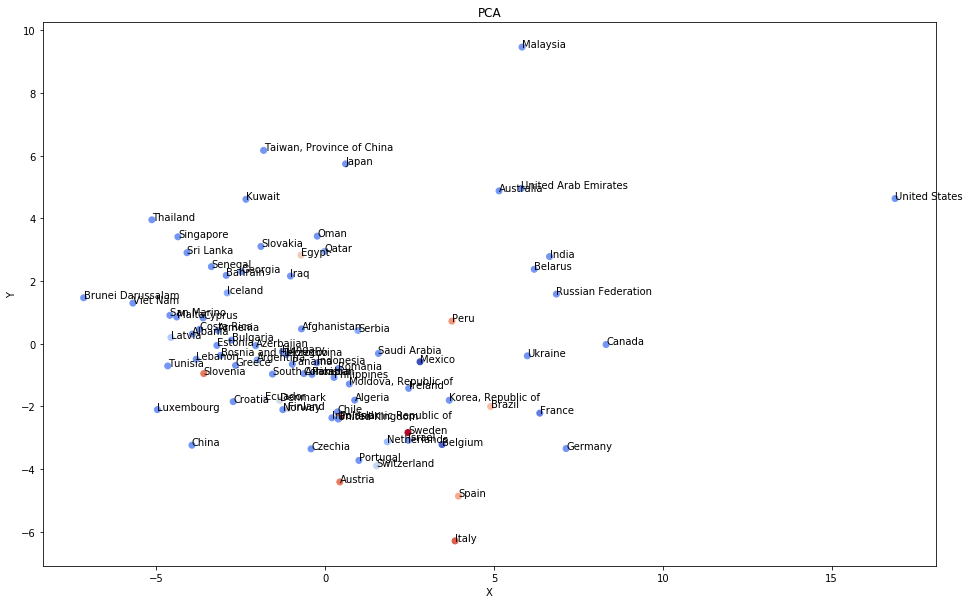

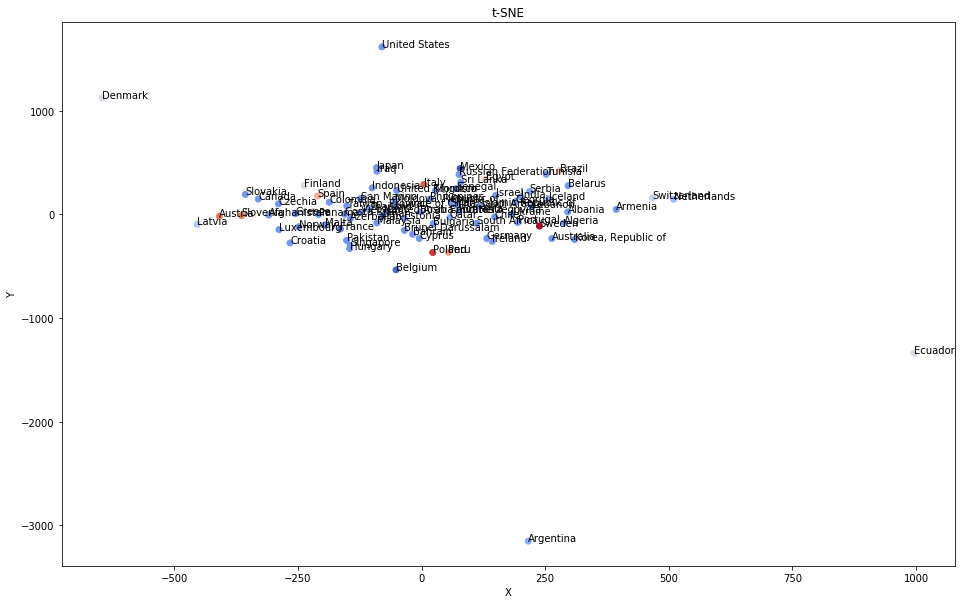

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def visualize_clusetrs_tsne(vectors, countries,  colors = None):
    tsne = TSNE(n_components=2, metric='euclidean', perplexity=7).fit_transform(vectors)
    fig, ax = plt.subplots()
    ax.scatter(tsne[:,0], tsne[:,1], c = colors, cmap=plt.cm.coolwarm)
    for i, txt in enumerate(countries):
        ax.annotate(txt, (tsne[i][0], tsne[i][1]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title("t-SNE")
    plt.show()
    
    
def visualize_clusetrs_pca(vectors, countries,  colors = None):
    X_std = StandardScaler().fit_transform(vectors)
    pca = PCA(n_components=2).fit(X_std).transform(X_std)
    fig, ax = plt.subplots()
    ax.scatter(pca[:,0], pca[:,1], c = colors, cmap=plt.cm.coolwarm)
    for i, txt in enumerate(countries):
        ax.annotate(txt, (pca[i][0], pca[i][1]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title("PCA")
    plt.show()
    
kmeans = KMeans(n_clusters=18).fit(vectors)
labels = kmeans.labels_


visualize_clusetrs_pca(vectors, countries, labels)
visualize_clusetrs_tsne(vectors, countries, labels)

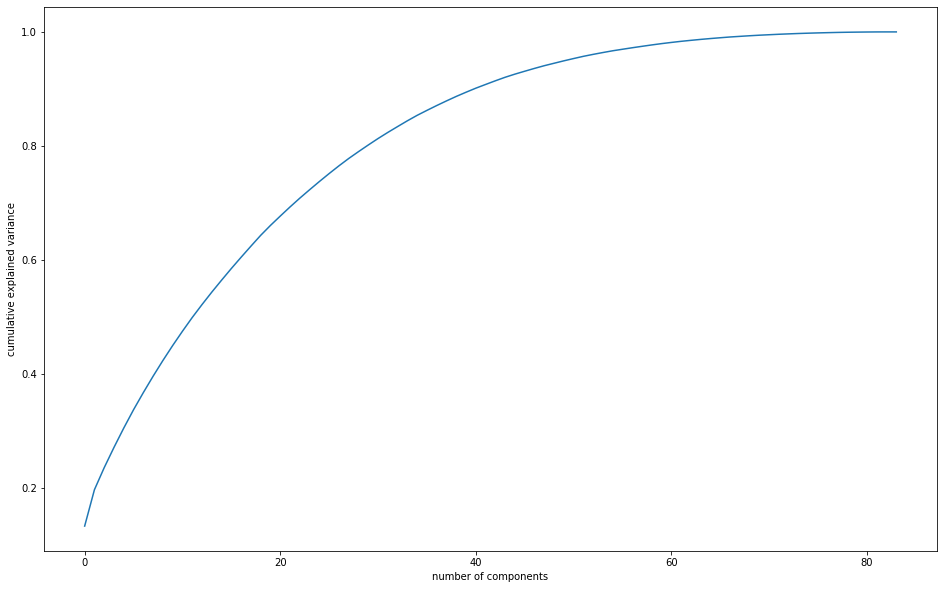

In [11]:
X_std = StandardScaler().fit_transform(vectors)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# Adding percentage of deths  and recovers to the vectors

In [33]:
vector_with_death_recover_percentge  = []
vector_combined = []
for country, vector in zip(countries, vectors):
    death_percentage  = []
    recover_percentage = []
    for day in range(day_range):
        confirmed = countries_with_enough_data[country][CONFIRMED][day]
        deaths = countries_with_enough_data[country][DEATHS][day]
        recovers = countries_with_enough_data[country][RECOVERED][day]
        death_percentage.append(deaths/confirmed)
        recover_percentage.append(recovers/confirmed)

    vector_with_death_recover_percentge.append(death_percentage + recover_percentage)
    vector_combined.append(np.append(vector, death_percentage + recover_percentage))
    
vector_with_death_recover_percentge = np.array(vector_with_death_recover_percentge)
vector_combined = np.array(vector_combined)
print(vector_combined.shape)
print(vector_with_death_recover_percentge.shape)

(84, 197)
(84, 80)


/home/julia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


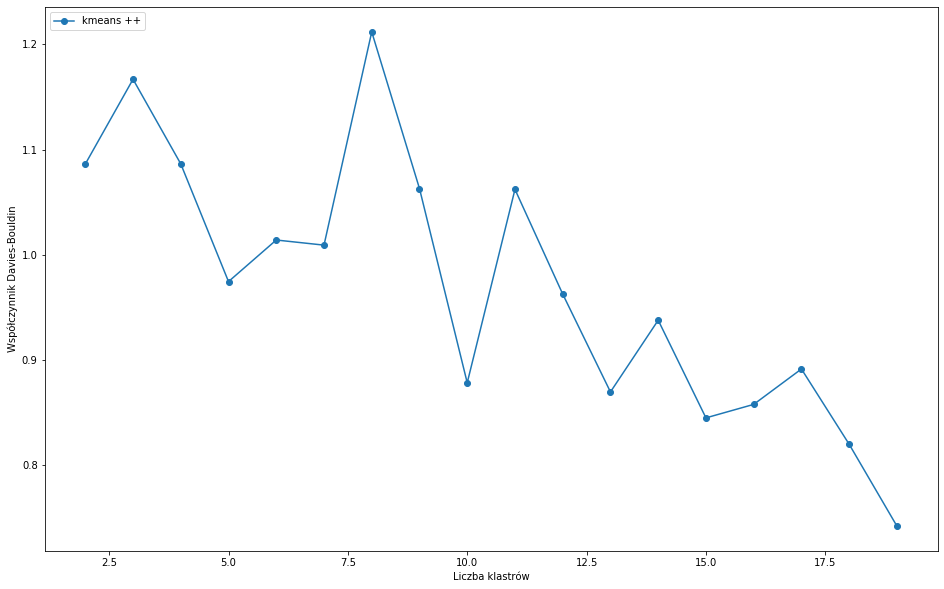

In [34]:
visualize_score_graph_number_of_clusters(vector_with_death_recover_percentge)

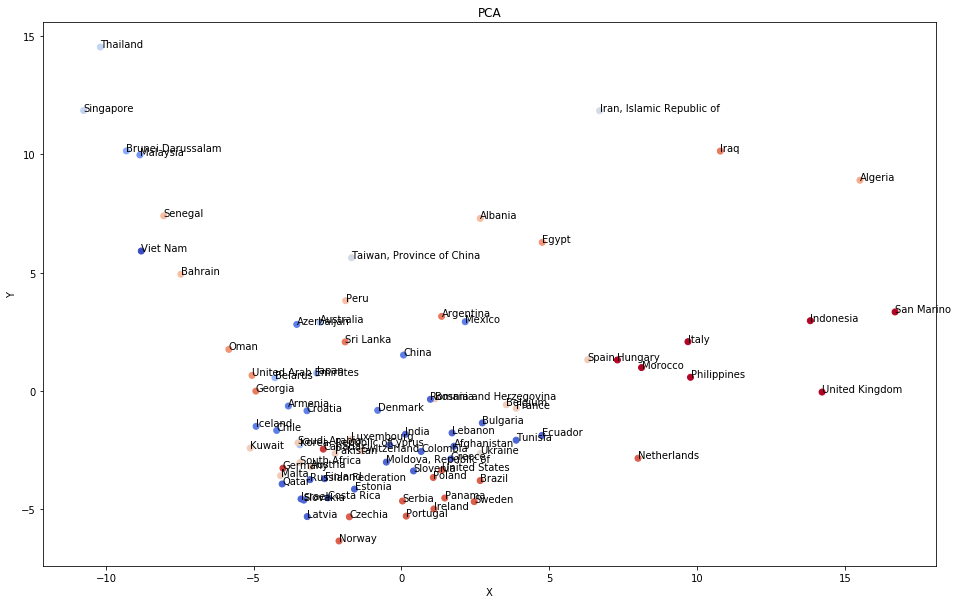

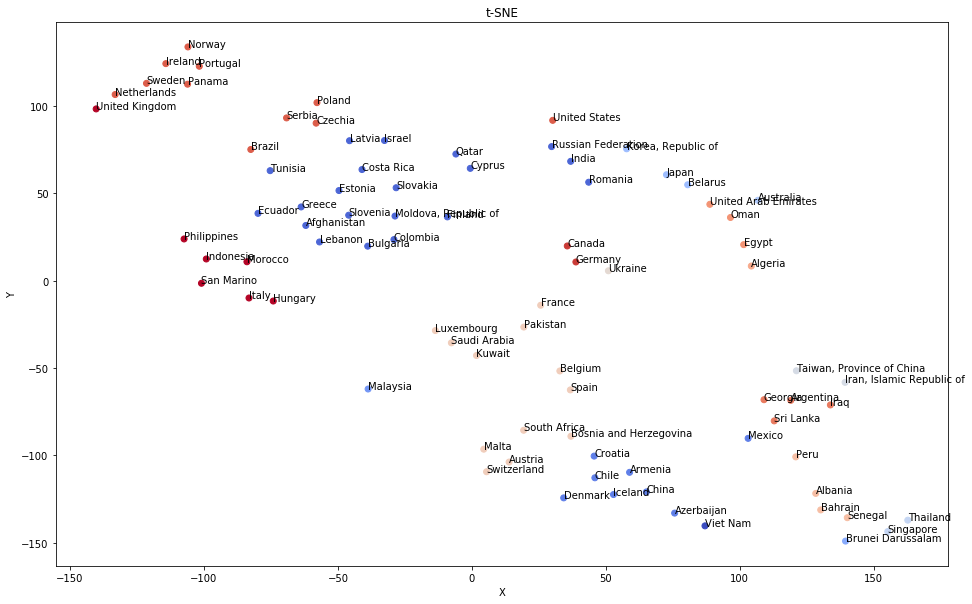

In [35]:
kmeans = KMeans(n_clusters=18).fit(vector_with_death_recover_percentge)
labels = kmeans.labels_
visualize_clusetrs_pca(vector_with_death_recover_percentge, countries, labels)
visualize_clusetrs_tsne(vector_with_death_recover_percentge, countries, labels)

/home/julia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


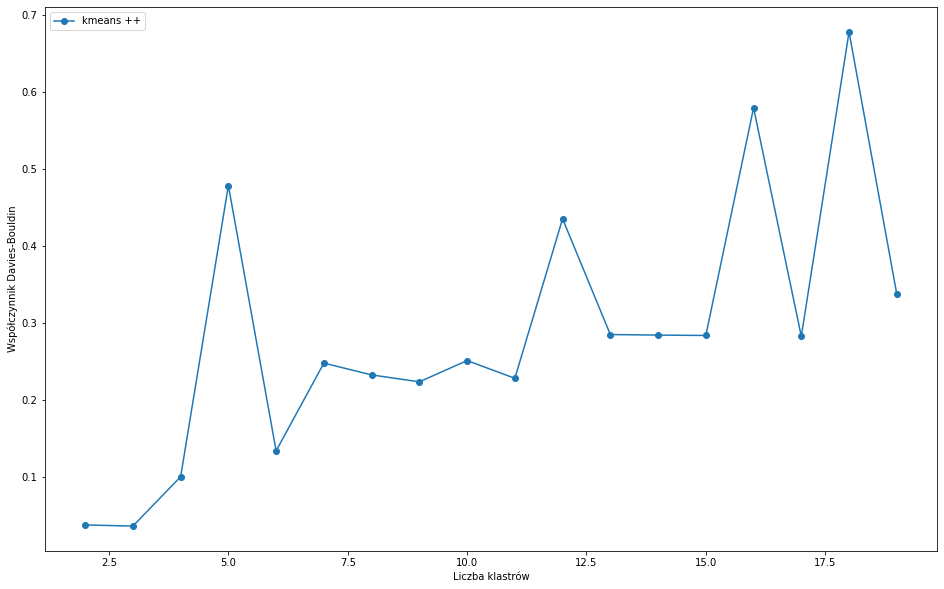

In [36]:
visualize_score_graph_number_of_clusters(vector_combined)

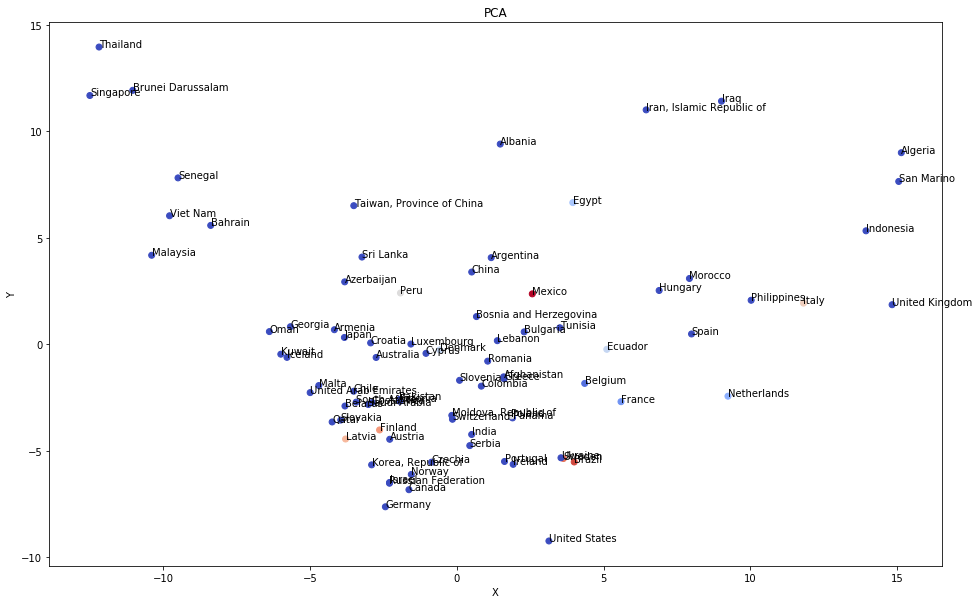

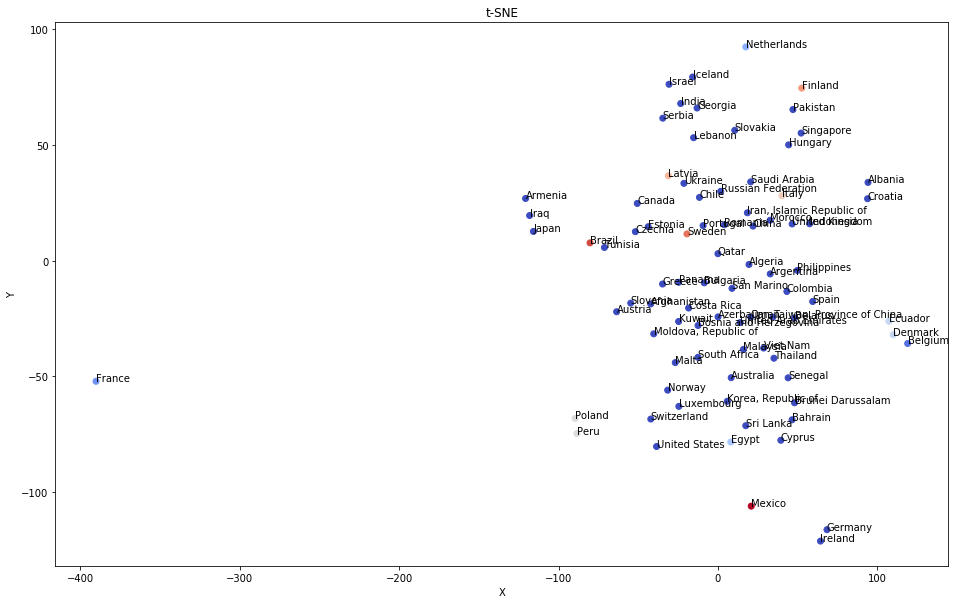

In [39]:
kmeans = KMeans(n_clusters=13).fit(vector_combined)
labels = kmeans.labels_
        
visualize_clusetrs_pca(vector_combined, countries, labels)
visualize_clusetrs_tsne(vector_combined, countries, labels)

# Adding percentage of influenced population

Getting the population df form  https://worldpopulationreview.com/ and adding the percentage of influenced population to the vector

In [40]:
population_df = pd.read_csv("popultion.csv")[['name', 'pop2020']]
population_df["pop2020"] *= 1000
population_df = population_df.astype({'pop2020': 'int32'}, copy=False)
print('Population of Poland is:', population_df.loc[population_df['name'] == 'Poland', "pop2020"].values[0])
countries_proper_names = {
    'DR Congo': 'Congo',
    'South Korea': 'Korea, Republic of',
    'Ivory Coast': 'Côte d\'Ivoire',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'Laos': 'Lao People\'s Democratic Republic',
    'Swaziland': 'Eswatini',
    'Macau': 'Macao',
    'Cape Verde': 'Cabo Verde',
    'United States Virgin Islands': 'United States',
}

population_df.replace({'name': countries_proper_names}, inplace=True)
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name for country in population_df['name']]
population_df['name'] = new_countries_names
population_df = population_df.groupby('name', as_index=False).sum()
population_df.head()

Population of Poland is: 37846611


,name,pop2020
0,Afghanistan,38928346
1,Albania,2877797
2,Algeria,43851044
3,American Samoa,55191
4,Andorra,77265


In [41]:
vector_with_population_percentge  = []
vector_combined_all = []
for country, vector in zip(countries, vector_combined):
    population_percentage  = []
    for day in range(day_range):
        confirmed = countries_with_enough_data[country][CONFIRMED][day]
        population = population_df.loc[population_df['name'] == country, "pop2020"].values[0]
        population_percentage.append(confirmed/population)

    vector_with_population_percentge.append(population_percentage)
    vector_combined_all.append(np.append(vector, population_percentage))
#     print(len(population_percentage))
    
vector_with_population_percentge = np.array(vector_with_population_percentge)
vector_combined_all = np.array(vector_combined_all)
print(vector_combined_all.shape)
print(vector_with_population_percentge.shape)

(84, 237)
(84, 40)


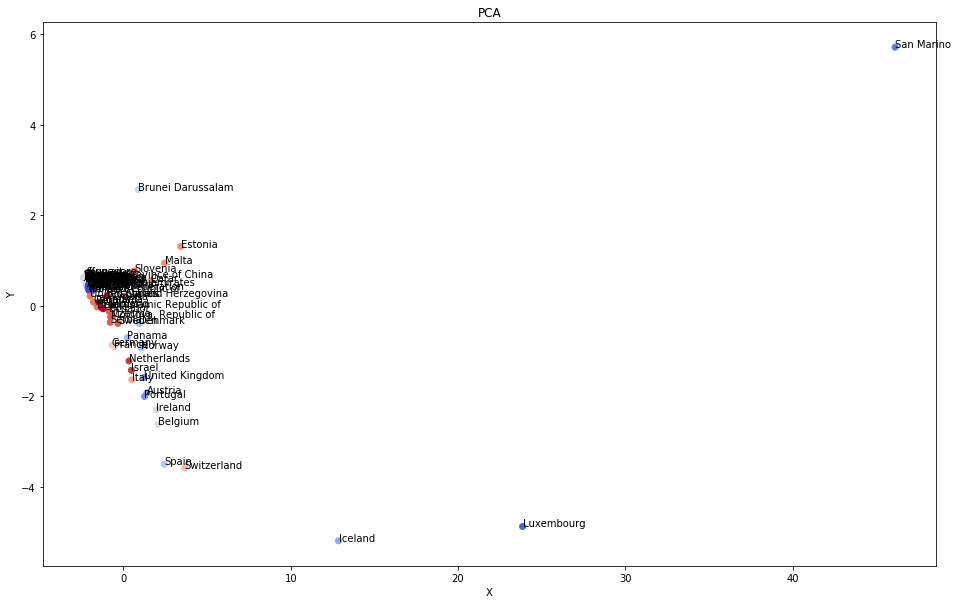

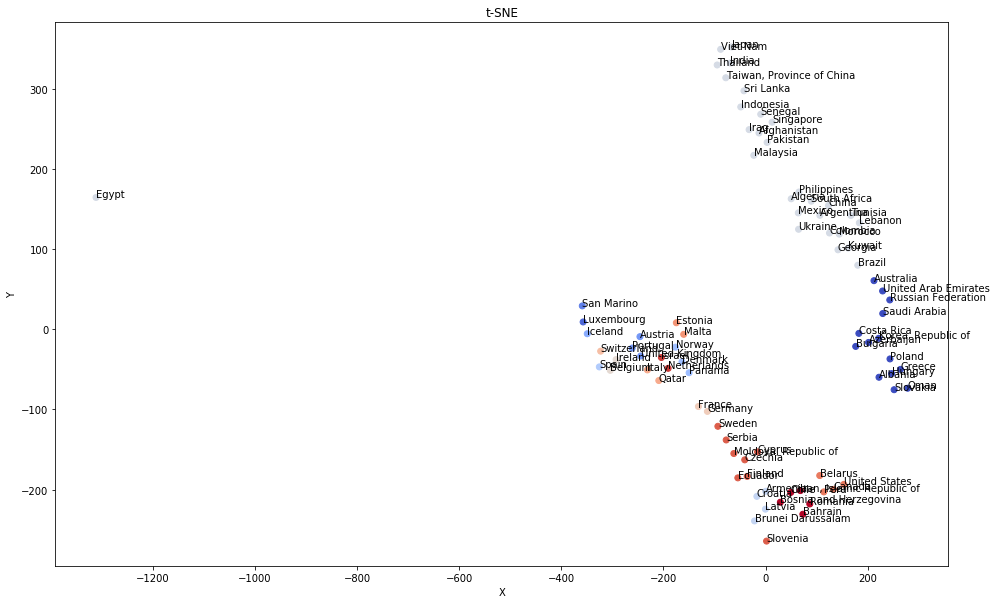

In [43]:
kmeans = KMeans(n_clusters=18).fit(vector_with_population_percentge)
labels = kmeans.labels_
visualize_clusetrs_pca(vector_with_population_percentge, countries, labels)
visualize_clusetrs_tsne(vector_with_population_percentge, countries, labels)

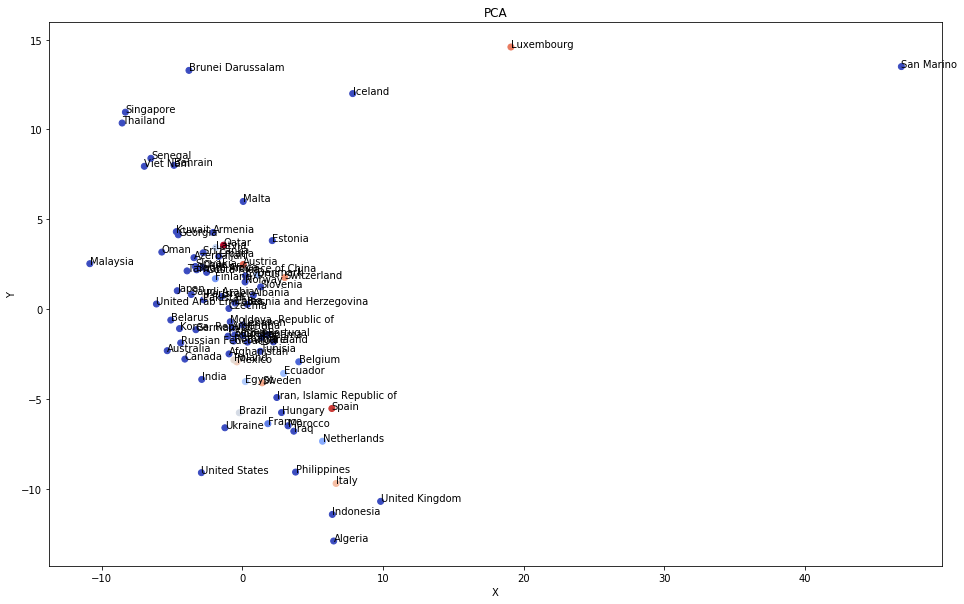

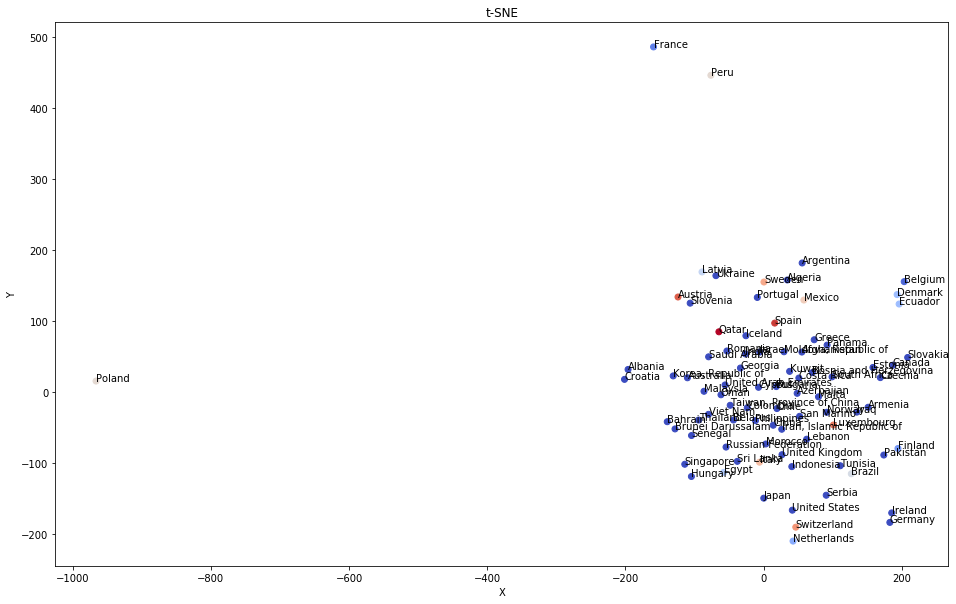

In [44]:
kmeans = KMeans(n_clusters=18).fit(vector_combined_all)
labels = kmeans.labels_
visualize_clusetrs_pca(vector_combined_all, countries, labels)
visualize_clusetrs_tsne(vector_combined_all, countries, labels)

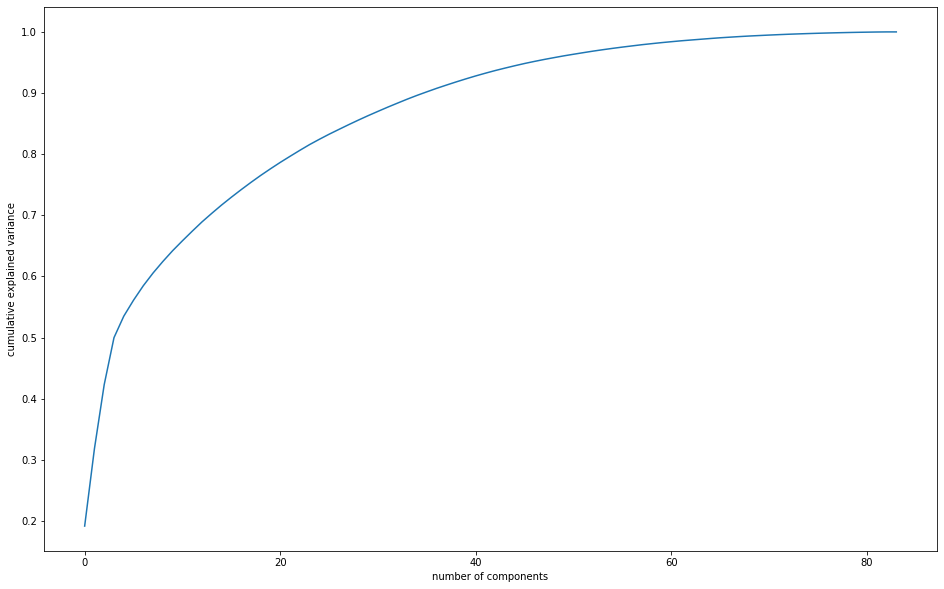

In [45]:
X_std = StandardScaler().fit_transform(vector_combined_all)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# Vizualising only 50 first components in pca

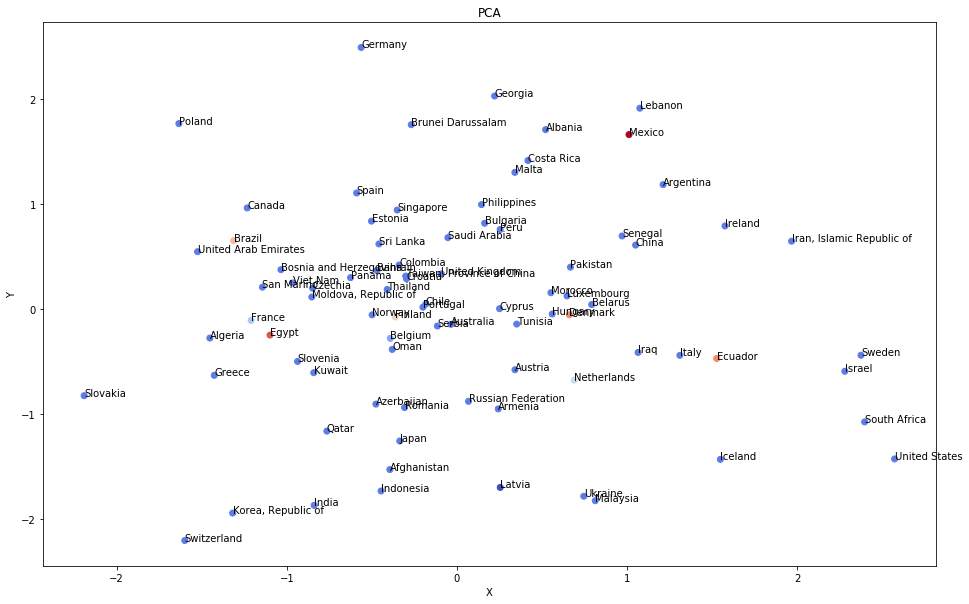

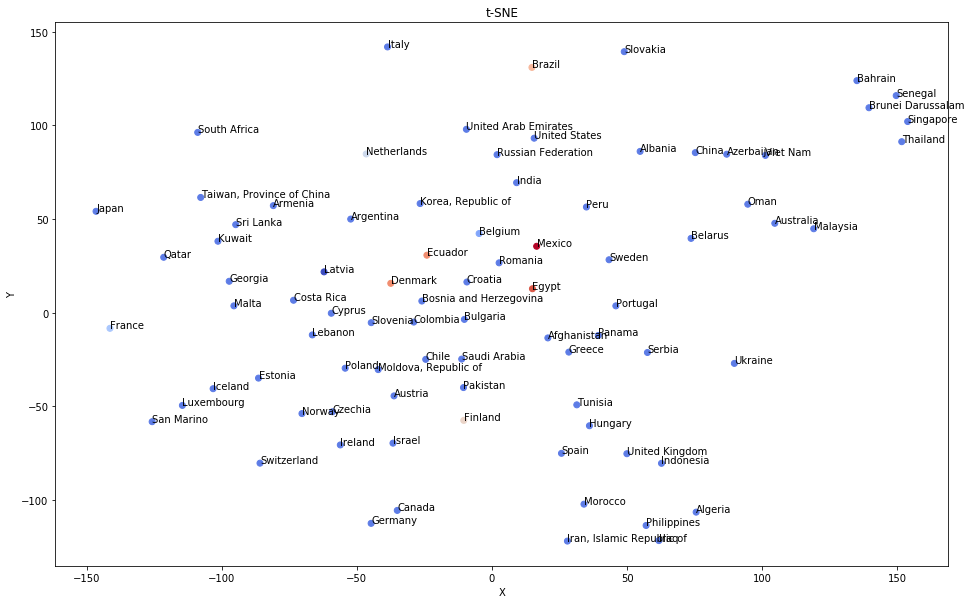

In [52]:
X_std = StandardScaler().fit_transform(vector_combined_all)
kmeans = KMeans(n_clusters=10).fit(vector_combined_all)
labels = kmeans.labels_
pca = PCA(n_components= 50).fit(X_std).transform(X_std)
visualize_clusetrs_pca(pca, countries, labels)
visualize_clusetrs_tsne(pca, countries, labels)
# print(pca.shape)